In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, requests, censusdata, zipfile
from pathlib import Path

####  Set raw and processed data directories

In [2]:
pwd

'C:\\Users\\nicho\\Documents\\ac209project\\notebooks'

In [4]:
raw_dir = Path('../raw_data/')
processed_dir = Path('../processed_data/')

assert(raw_dir.exists() & processed_dir.exists()), 'data directories not valid'

True

#### Pull downloaded Kaggle data (requires auth) 

In [5]:
kaggle_demos = pd.read_csv(raw_dir/'us_county.csv')
kaggle_demos.head()

,fips,county,state,state_code,male,female,median_age,population,female_percentage,lat,long
0,1001,Autauga County,Alabama,AL,26874,28326,37.8,55200,51.315217,32.534923,-86.642730
1,1003,Baldwin County,Alabama,AL,101188,106919,42.8,208107,51.376936,30.727479,-87.722564
2,1005,Barbour County,Alabama,AL,13697,12085,39.9,25782,46.873788,31.869581,-85.393210
3,1007,Bibb County,Alabama,AL,12152,10375,39.9,22527,46.055844,32.998628,-87.126475
4,1009,Blount County,Alabama,AL,28434,29211,40.8,57645,50.673953,33.980869,-86.567380


#### Request IHME health data

In [6]:
if 'ihme_health.csv' not in [_.name for _ in raw_dir.glob('*')]:
    h_url = 'http://ghdx.healthdata.org/sites/default/files/record-attached-files/'
    h_file = 'IHME_USA_COUNTY_LE_MORTALITY_RISK_1980_2014_NATIONAL_STATES_DC_CSV.zip'
    r = requests.get(h_url+h_file, stream=True)
    with open(raw_dir/'ihme_health.zip', 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)
    with zipfile.ZipFile(raw_dir/'ihme_health.zip', 'r') as zip_ref:
        zip_ref.extractall(raw_dir/'imhe_health/')
    health_pth = Path(raw_dir/'imhe_health/')
    assert health_pth.exists(), 'no health files found'
    files = health_pth.glob('*.csv')
    
    health_dfs = []
    for f in files:
        try:
            df = pd.read_csv(f)
            max_year = df.year_id.max()
            # logic to get single rows for pivot table
            df = df[(df.year_id == max_year) & (df.sex == "Both") \
                    & ((df.age_name == "0") | (df.age_name == "65 to 85"))]
            pvt = pd.pivot_table(df, values = 'val', columns = 'measure_name',
                    index=['FIPS', 'location_name']).reset_index()
            health_dfs.append(pvt)
        except Exception as e:
            print(e); continue
            
    health = pd.concat([_ for _ in health_dfs if _.shape[0] > 1])
    health.to_csv(raw_dir/'ihme_health.csv')
else:
    health = pd.read_csv(raw_dir/'ihme_health.csv')

'>=' not supported between instances of 'str' and 'float'


In [7]:
health.head()

measure_name,FIPS,location_name,Life expectancy,Mortality risk
0,1,Alabama,75.648292,57.460523
1,1001,Autauga County,75.668023,58.373616
2,1003,Baldwin County,78.075681,50.486669
3,1005,Barbour County,75.421683,56.251879
4,1007,Bibb County,73.967404,61.110046


#### Census income data

In [8]:
r = requests.get('https://www2.census.gov/programs-surveys/saipe/datasets/2018/2018-state-and-county/est18all.txt')
t = r.text

lines = t.split('\n')
income_dict = {}
for l in lines:
    name = l[193:238].strip()
    if name == '': continue
    fin_demos = {
        'fips_state': l[0:2].strip(),
        'fips_county': l[3:6].strip(),
        'all_poverty': l[7:15].strip(),
        'median_hh_income': l[133:139].strip()
    }
    income_dict[name] = fin_demos

income = pd.DataFrame(income_dict).T
def fix_fips(s):
    if len(s) == 3: return s
    elif len(s) == 2: return f'0{s}'
    else: return f'00{s}'
    
# fix erros in Kalawao county
income = income.replace('.', np.nan)
income['all_poverty'] = income.all_poverty.astype(float)
income['median_hh_income'] = income.median_hh_income.astype(float)

income['fips_county_pad'] = income.fips_county.map(fix_fips)
income['fips'] = (income.fips_state + income.fips_county_pad).astype(int)
income.head()

,fips_state,fips_county,all_poverty,median_hh_income,fips_county_pad,fips
United States,00,0,41852315.0,61937.0,000,0
Alabama,01,0,801758.0,49881.0,000,1000
Autauga County,01,1,7587.0,59338.0,001,1001
Baldwin County,13,9,9313.0,42727.0,009,13009
Barbour County,54,1,3110.0,39776.0,001,54001


#### Merge

In [9]:
demos = pd.merge(
    kaggle_demos, health.set_index('FIPS')[['Life expectancy', 'Mortality risk']],
    left_on='fips', right_index=True).merge(
        income.set_index('fips')[['all_poverty', 'median_hh_income']],
        left_on='fips', right_index=True)

def fix_colname(s): return s.lower().strip().replace(' ', '_')
demos.columns = [fix_colname(_) for _ in demos.columns]

demos['pct_impoverished'] = demos.all_poverty.div(demos.population)

#### Quick vis check

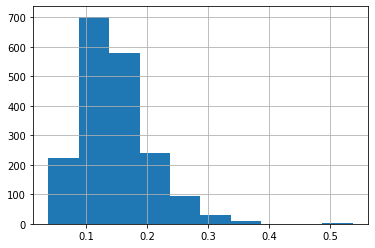

In [10]:
demos.pct_impoverished.hist()

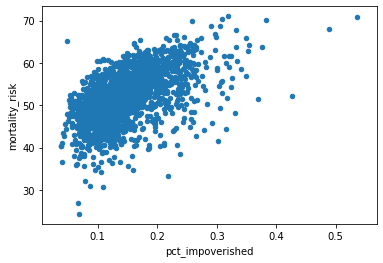

In [11]:
demos.plot.scatter('pct_impoverished', 'mortality_risk')